In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib
import pandas as pd
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment as linear_assignment


2024-06-19 01:03:36.606682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Function to calculate clustering accuracy
def accuracy(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_assignment(w.max() - w)
    
    return w[row_ind, col_ind].sum() * 1.0 / y_pred.size

In [4]:
# Load data
data_dir = '../data_set'  # relative path to the data set
data_dir = pathlib.Path(data_dir)
batch_size = 32
img_height = 224
img_width = 224

ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,  
    label_mode='int')

class_names = ds.class_names
print(class_names)

Found 5017 files belonging to 2 classes.
['Abstract_Expressionism', 'Cubism']


2024-06-19 01:45:49.728611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


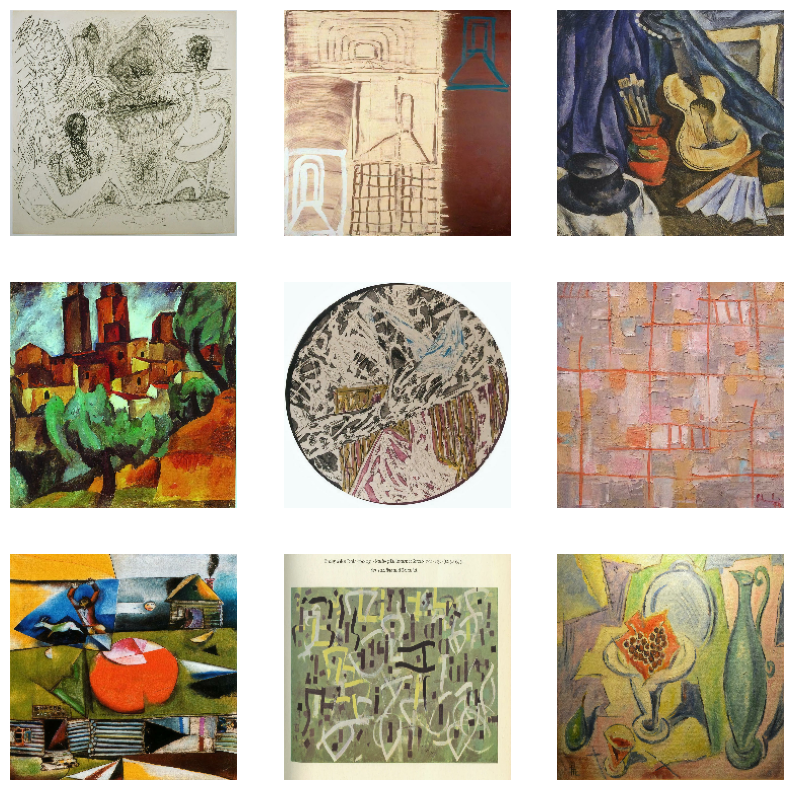

In [5]:
# Display a few images
plt.figure(figsize=(10, 10))
for images, labels in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [11]:
# Extract features using a pre-trained model
preprocess_input = tf.keras.applications.densenet.preprocess_input

base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights=None,  # Set to None to load weights manually
                                               pooling='avg')

# Load weights manually
weights_path = '../Model/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(weights_path)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
outputs = base_model(x, training=False)
model = tf.keras.Model(inputs, outputs)

In [12]:
features = []
labels = np.array([])
for x, y in ds:
    features.append(model.predict(x))
    labels = np.concatenate([labels, y])

features = np.asarray(features).reshape(-1, 1024)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━

2024-06-19 02:13:55.931011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (157,) + inhomogeneous part.

In [13]:
features = np.vstack(features)

In [18]:
# Define and pre-train a simple fully-connected autoencoder
def autoencoder(dims, act='relu', init='glorot_uniform'):
    input_img = tf.keras.layers.Input(shape=(dims[0],), name='input')
    x = input_img
    for dim in dims[1:-1]:
        x = tf.keras.layers.Dense(dim, activation=act, kernel_initializer=init)(x)
    encoded = tf.keras.layers.Dense(dims[-1], kernel_initializer=init, name='encoded')(x)
    x = encoded
    for dim in dims[-2:0:-1]:
        x = tf.keras.layers.Dense(dim, activation=act, kernel_initializer=init)(x)
    decoded = tf.keras.layers.Dense(dims[0], kernel_initializer=init)(x)
    return tf.keras.models.Model(input_img, decoded), tf.keras.models.Model(input_img, encoded)


In [19]:
dims = [1024, 500, 500, 2000, 10]
autoencoder, encoder = autoencoder(dims)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(features, features, batch_size=256, epochs=200)

# Save the autoencoder model
save_dir = '../Model'
autoencoder.save(save_dir + '/pretrained_autoencoder.h5')

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.6111
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.3867
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.3793
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.3768
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.3711
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.3543
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.3360
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.3254
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.3138
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.3020
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.2922
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.2844
Epoch 13/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.2754
Epoch 14/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.2701
Epoch 15/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [20]:
# Define the deep clustering layer
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, n_clusters, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        self.clusters = self.add_weight(shape=(self.n_clusters, input_shape[1]),
                                        initializer='glorot_uniform',
                                        trainable=True)

    def call(self, inputs):
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / 1.0))
        q **= 1.5
        q = q / tf.reduce_sum(q, axis=1, keepdims=True)
        return q

In [21]:
n_clusters = 10
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = tf.keras.models.Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

In [22]:
# Initialize cluster centroids using k-means
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(features))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [23]:
# Compute auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [24]:
# Train the model
batch_size = 128
maxiter = 8000
update_interval = 140
tol = 0.001
index_array = np.arange(features.shape[0])
y_pred_last = np.copy(y_pred)

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(features, verbose=0)
        p = target_distribution(q)
        embedded_features = encoder.predict(features)
        y_pred = q.argmax(1)
        if labels is not None:
            acc = accuracy(labels, y_pred)
            nmi = normalized_mutual_info_score(labels, y_pred)
            ars = adjusted_rand_score(labels, y_pred)
            ss = silhouette_score(embedded_features, y_pred)
            chs = calinski_harabasz_score(embedded_features, y_pred)
            print(f'Iter {ite}: acc = {acc:.5f}, nmi = {nmi:.5f}, ars = {ars:.5f}, ss = {ss:.5f}, chs = {chs:.5f}')

        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print(f'delta_label {delta_label} < tol {tol}')
            print('Reached tolerance threshold. Stopping training.')
            break

    idx = index_array[ite * batch_size: min((ite + 1) * batch_size, features.shape[0])]
    model.train_on_batch(x=features[idx], y=p[idx])

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Iter 0: acc = 0.24317, nmi = 0.12594, ars = 0.07180, ss = 0.07677, chs = 299.70529


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Iter 140: acc = 0.33107, nmi = 0.12641, ars = 0.08973, ss = 0.14649, chs = 623.84798
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Iter 280: acc = 0.33107, nmi = 0.12641, ars = 0.08973, ss = 0.14649, chs = 623.85374
delta_label 0.0 < tol 0.001
Reached tolerance threshold. Stopping training.


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


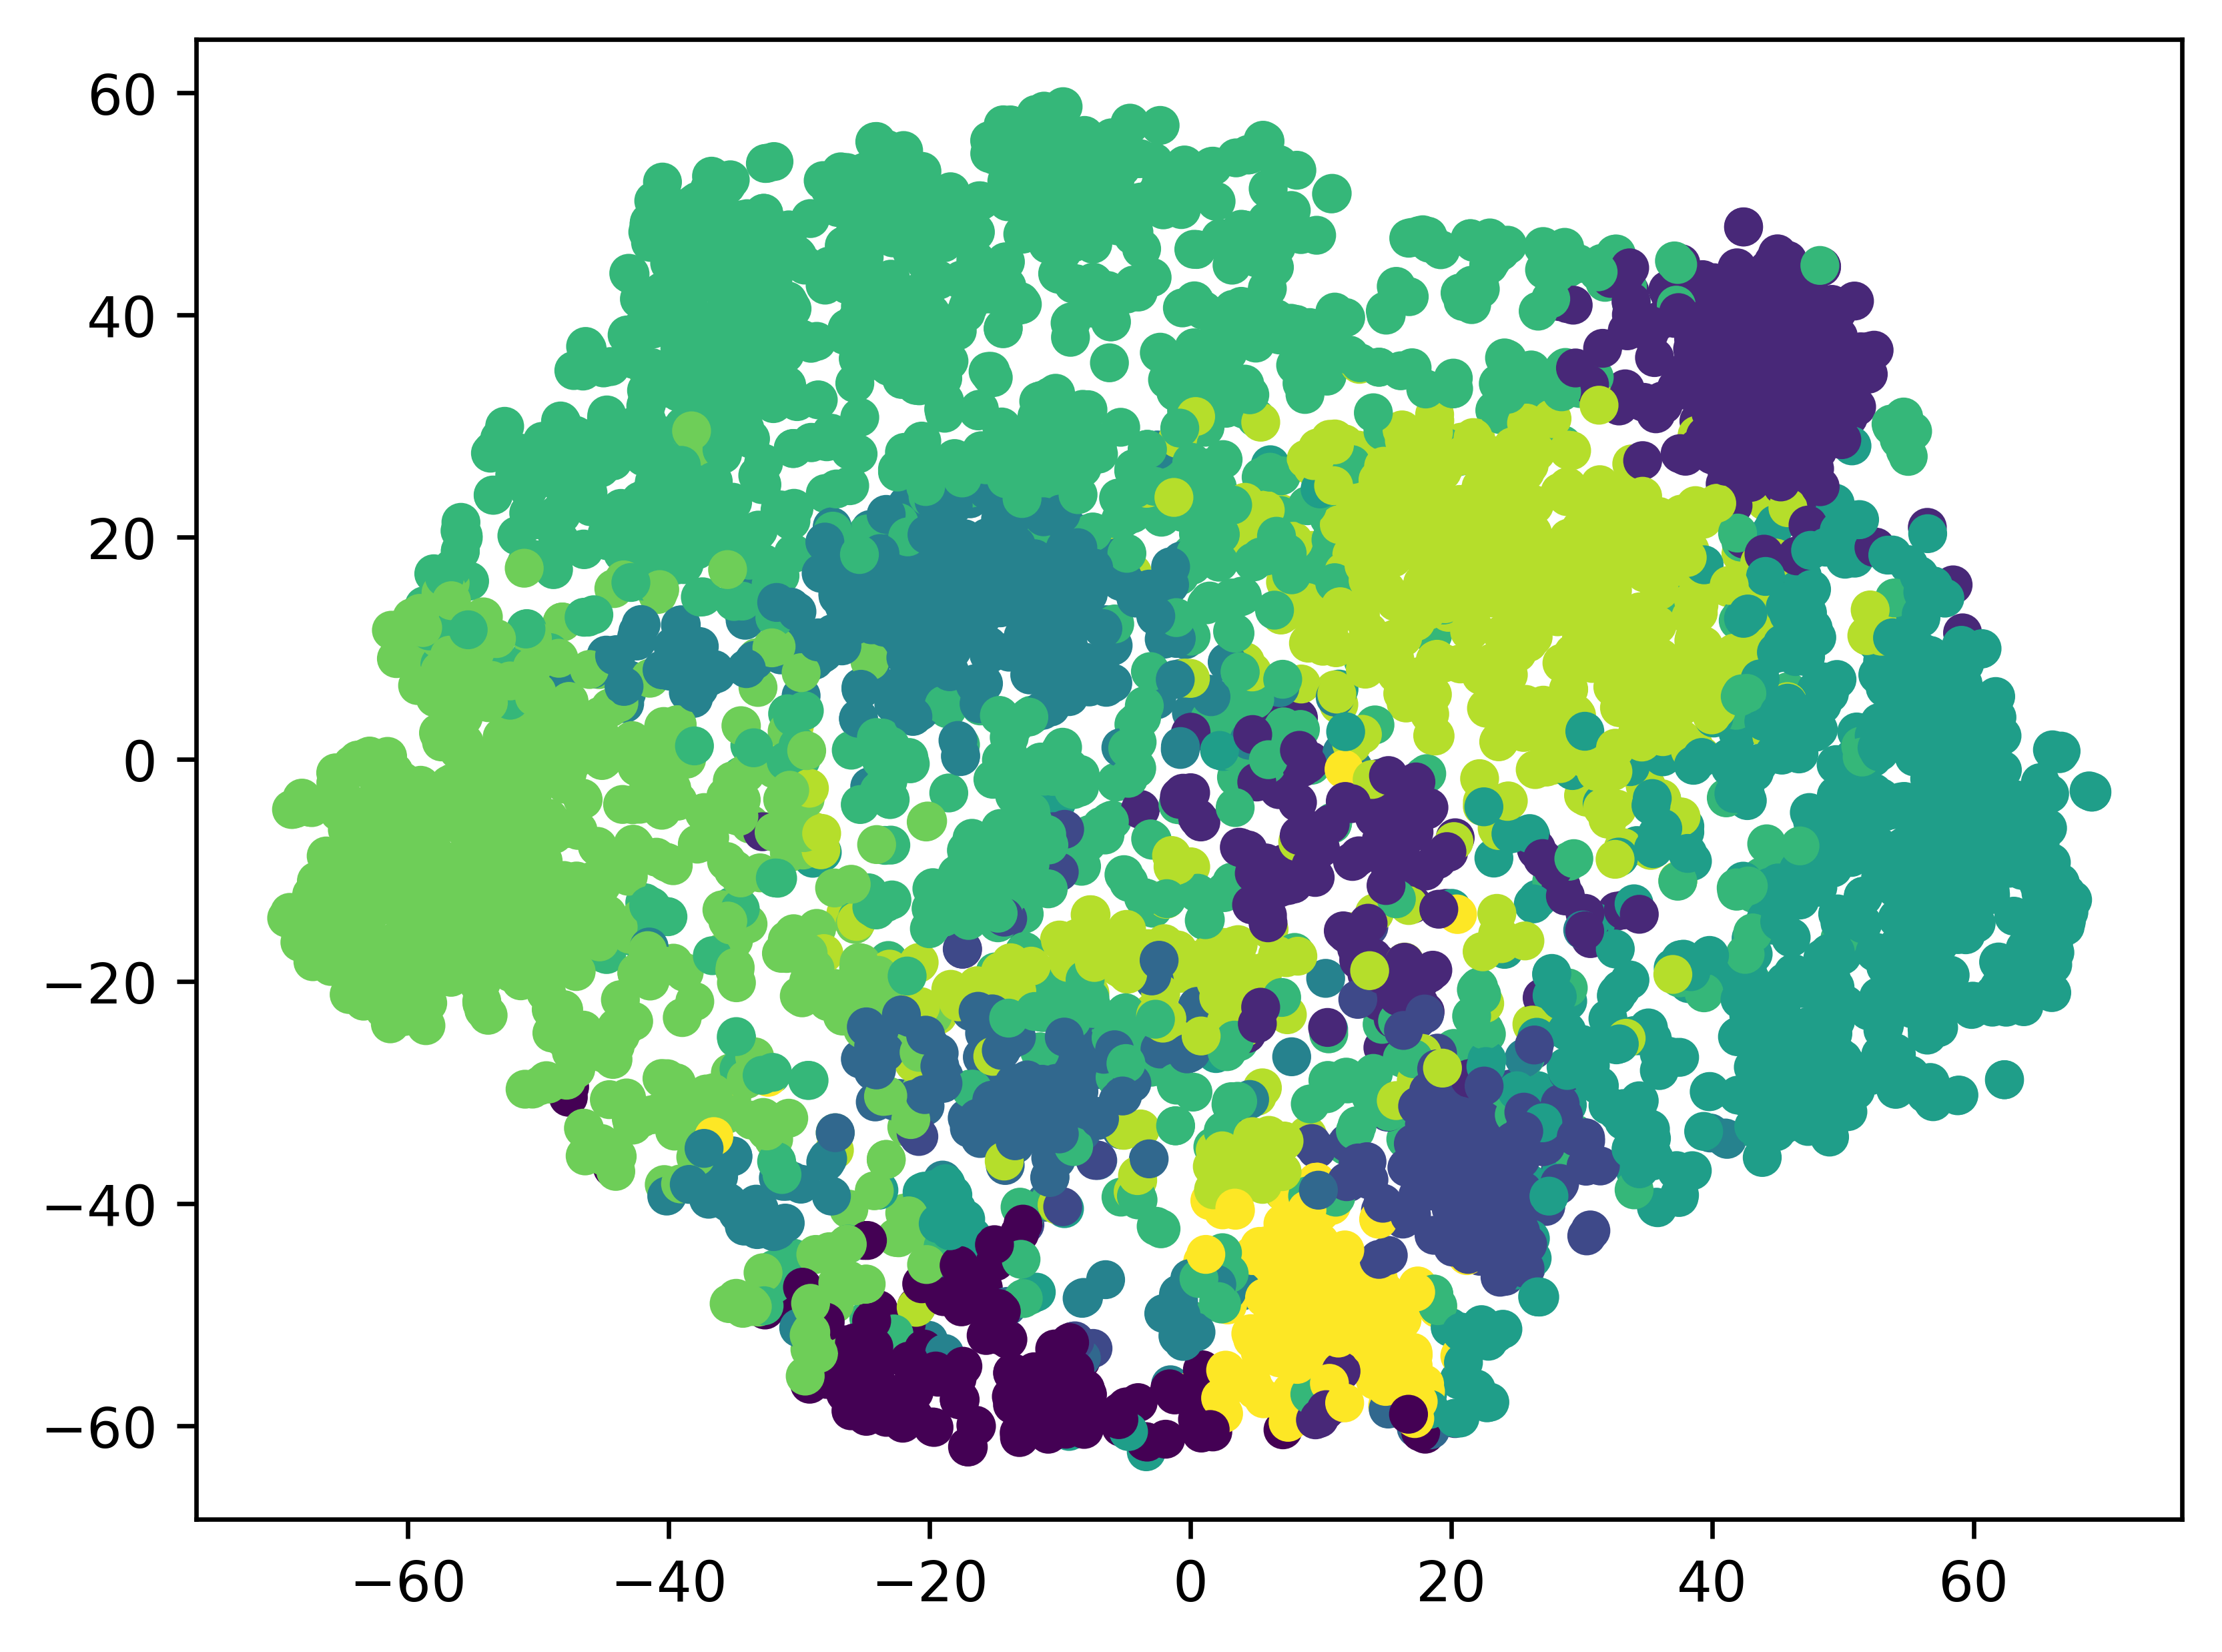

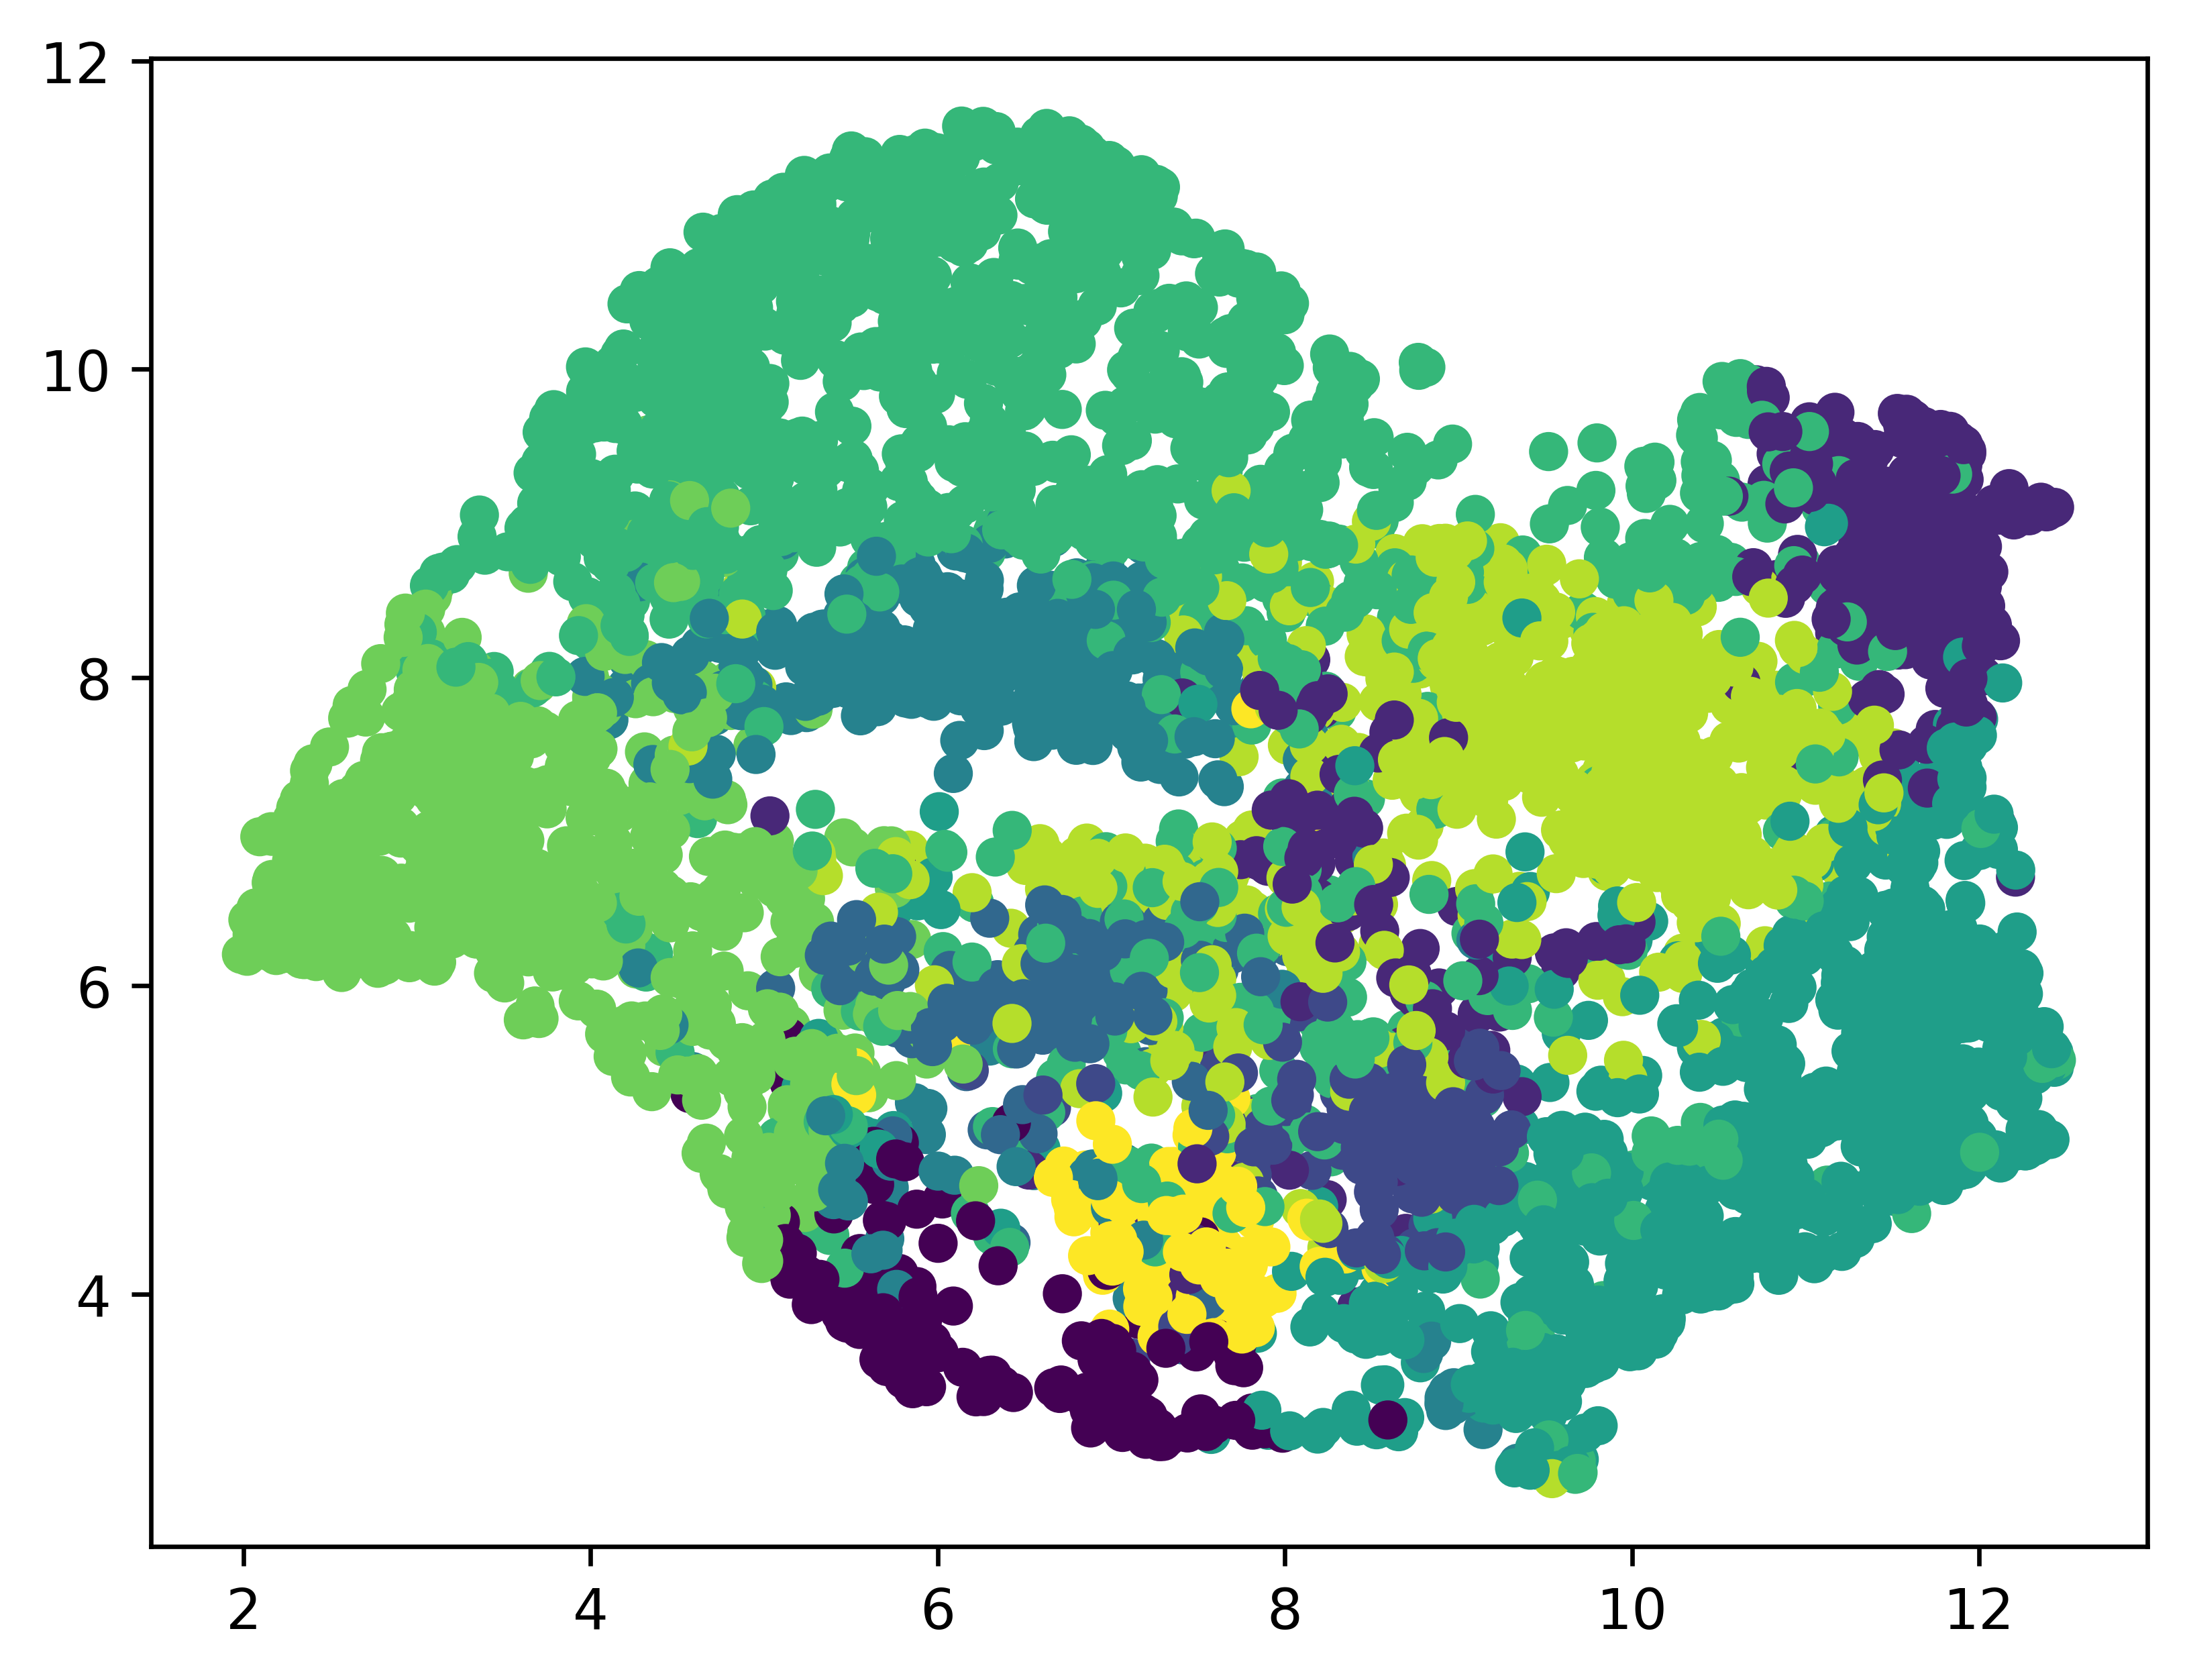

In [25]:
# Visualize the clusters
embedded_features = encoder.predict(features)
tsne = TSNE(n_components=2, random_state=42)
tsne_embedding = tsne.fit_transform(embedded_features)

plt.figure(dpi=600)
plt.scatter(*zip(*tsne_embedding[:, :2]), c=y_pred, cmap='viridis')
plt.show()

reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(embedded_features)

plt.figure(dpi=600)
plt.scatter(*zip(*umap_embedding[:, :2]), c=y_pred, cmap='viridis')
plt.show()

In [26]:
# Sample and display images from a specific cluster
sample_paths = [path for batch in ds for path in batch[0]]
sample_df = pd.DataFrame(sample_paths, columns=['path'])
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
df = pd.concat([sample_df, y_pred_df], axis=1)

cluster = 1
sample = df[df['y_pred'] == cluster].sample(n=50, random_state=42)

for index, row in sample.iterrows():
    img = mpimg.imread(row['path'])
    plt.imshow(img)
    plt.axis("off")
    plt.show()

2024-06-19 02:46:07.281937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ValueError: Must pass 2-d input. shape=(5017, 224, 224, 3)